In [4]:
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

# Basics
import os
import sys
import time

import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Single dataset
import hddm_wfpt
import hssm
import pytensor  # Graph-based tensor library
import jax
import bambi as bmb # Model construction 
import arviz as az  # Visualization

pytensor.config.floatX = "float32"
jax.config.update("jax_enable_x64", False)

In [6]:
# get hierarchical data
group_v = 1
group_a = 2.0
group_z = 0.1
group_t = 0.1

# demo with a very minimal and limited dataset
nsubj = 20
ntrials = 50

# note: these params can sometimes result in -ve rts
subj_v = np.random.normal(group_v, 0.05, nsubj)
subj_a = np.random.normal(group_a, 0.05, nsubj)
subj_z = np.random.normal(group_z, 0.05, nsubj)
subj_t = np.random.normal(group_t, 0.05, nsubj)

In [7]:
v_arr = np.zeros(nsubj)
a_arr = v_arr.copy()
z_arr = v_arr.copy()
t_arr = v_arr.copy()
subj_arr = np.zeros(nsubj * ntrials)

for subj in range(nsubj):
    s_ind = subj * ntrials
    subj_arr[s_ind:s_ind + ntrials] = np.array([subj])
    v_arr[subj:subj + 1] = np.array([subj_v[subj]])
    a_arr[subj:subj + 1] = np.array([subj_a[subj]])
    z_arr[subj:subj + 1] = np.array([subj_z[subj]])
    t_arr[subj:subj + 1] = np.array([subj_t[subj]])


hier_theta = np.vstack([v_arr, a_arr, z_arr, t_arr]).T

In [8]:
# Call the simulator function
dataset = hssm.simulate_data(model = 'ddm',
							 theta = hier_theta,
                             size = ntrials,
							 )

dataset['participant_id'] = subj_arr

dataset

,rt,response,participant_id
0,0.355936,-1.0,0.0
1,5.987308,1.0,0.0
2,0.060208,-1.0,0.0
3,2.174563,1.0,0.0
4,2.910911,1.0,0.0
...,...,...,...
995,0.881931,-1.0,19.0
996,4.515815,1.0,19.0
997,0.299061,-1.0,19.0
998,4.395689,1.0,19.0


### Non-hierarchical estimation

In [9]:
non_hier_model = hssm.HSSM(data=dataset, hierarchical=False, p_outlier=None,
                             include = [
                                            {
                                                "name": "v",
                                                "formula": "v ~ C(participant_id)",
                                            },
                                            {
                                                "name": "t",
                                                "formula": "t ~ C(participant_id)",
                                            },
                                            {
                                                "name": "a",
                                                "formula": "a ~ C(participant_id)",
                                            },  
                                            {
                                                "name": "z",
                                                "formula": "z ~ C(participant_id)",
                                            }
                                        ],
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


In [10]:
print(non_hier_model)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Formula: v ~ C(participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_C(participant_id) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ C(participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_C(participant_id) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ C(participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_C(participant_id) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ C(participant_id)
    Priors:
        t_Intercept ~ Gamma(mu: 0.20000000298023224, sigma: 0.20000000298023224)
        t_C(participant_id) ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit boun

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/prior.py:78: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}"


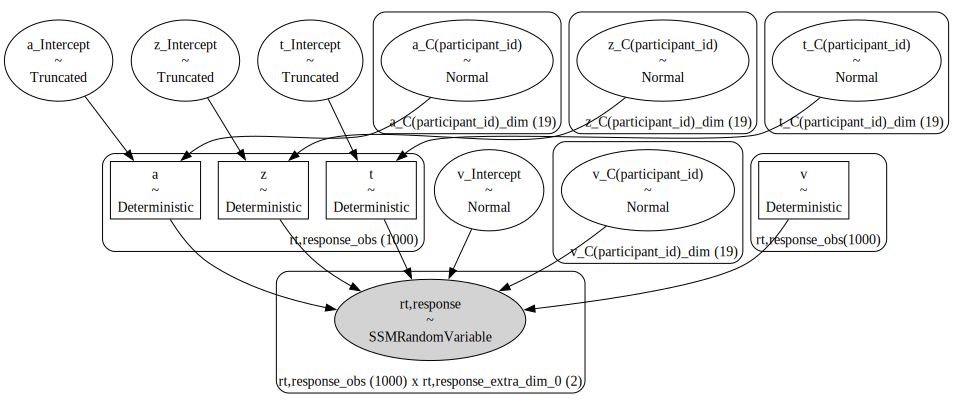

In [11]:
non_hier_model.graph()

In [24]:
infer_data_nh = non_hier_model.sample(
    sampler="nuts_numpyro",  
    cores=2,  
    chains=2,  
    draws=500,  
    tune=1000,  
    idata_kwargs=dict(log_likelihood=True),  
) 

/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x325a76040>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x32c88faf0>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x32c8ae9e0>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x32c8acf30>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-pac

### Hierarchical estimation

In [25]:
hier_model = hssm.HSSM(data=dataset, hierarchical=True, p_outlier=None)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.


In [26]:
print(hier_model)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + (1|participant_id)
    Priors:
        a_Intercept ~ Gamma(mu: 1.5, sigma: 0.75)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Beta(alpha: 10.0, beta: 10.0)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.30000001192092896))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1 + (1|participant_id)
    Priors:
        t_Intercept ~ Gamma(mu: 0

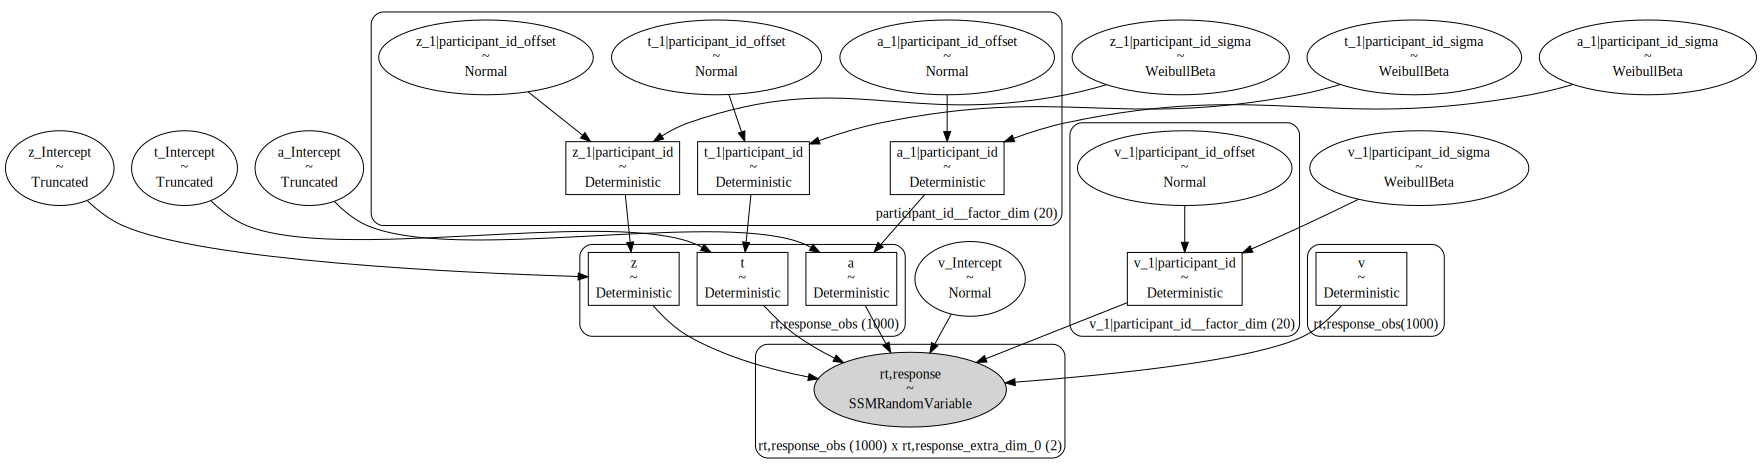

In [27]:
hier_model.graph()

In [28]:
infer_data_h = hier_model.sample(
    sampler="nuts_numpyro",  
    cores=2,  
    chains=2,  
    draws=500,  
    tune=1000,  
    idata_kwargs=dict(log_likelihood=True),  
) 

/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x32c88faf0>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x32c8adf60>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x32c174440>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-packages/ipykernel/iostream.py:153: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x32c1760b0>
  self._event_pipes[threading.current_thread()] = event_pipe
/Users/krishnbera/anaconda3/envs/hssm_py3_11/lib/python3.11/site-pac

### Comparison of summary statistics
While only group-level params are shown here, the subject-level parameters can also be compared. R-hat for hierarchical estimation is in general better than the non-hierarchical case. Moreover, the hdi intervals are more accurate and less uncertain. 

The core point here being that hierarchical estimation can benefit from the "grouped" treatment of data even in low-data regimes. The non-hierarchical estimation does not leverage information from other subjects to inform the estimation and hence, the MCMC convergence is slow. 

In [29]:
az.summary(infer_data_nh, var_names=["a_Intercept", "z_Intercept", "t_Intercept", "v_Intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_Intercept,1.954,0.056,1.857,2.077,0.009,0.007,36.0,160.0,1.06
z_Intercept,0.128,0.019,0.095,0.160,0.004,0.003,19.0,23.0,1.08
t_Intercept,0.053,0.016,0.026,0.078,0.006,0.005,9.0,47.0,1.19
v_Intercept,0.974,0.065,0.846,1.077,0.027,0.020,6.0,21.0,1.29


In [30]:
az.summary(infer_data_h, var_names=["a_Intercept", "z_Intercept", "t_Intercept", "v_Intercept"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_Intercept,1.974,0.038,1.902,2.038,0.001,0.001,835.0,786.0,1.0
z_Intercept,0.125,0.006,0.116,0.137,0.000,0.000,585.0,686.0,1.0
t_Intercept,0.070,0.006,0.060,0.081,0.000,0.000,456.0,587.0,1.0
v_Intercept,0.993,0.039,0.918,1.063,0.002,0.001,559.0,682.0,1.0
